In [2]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.applications.mobilenet import preprocess_input

In [3]:
#import data
data = np.load('Downloads\images.npy', allow_pickle=True)
data[1][1]
data[1][0]

array([[[207, 216, 227, 255],
        [206, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 216, 227, 255],
        ...,
        [ 35,  32,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       [[207, 216, 227, 255],
        [207, 216, 227, 255],
        [207, 215, 227, 255],
        ...,
        [ 35,  33,  33, 255],
        [ 35,  33,  34, 255],
        [ 35,  33,  34, 255]],

       ...,

       [[ 31,  21,  17, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        [ 31,  22,  18, 255],
        ...,
        [  0,   1,   4, 255],
        [  0,   1,   4, 255],
        [  0,   1,   4, 255]],

       [[ 31

In [4]:
data.shape[0]

409

In [5]:
masks = np.zeros((int(data.shape[0]), 224, 224))
Images = np.zeros((int(data.shape[0]), 224, 224, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    Images[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 224)
        x2 = int(i["points"][1]['x'] * 224)
        y1 = int(i["points"][0]['y'] * 224)
        y2 = int(i["points"][1]['y'] * 224)
        masks[index][y1:y2, x1:x2] = 1

In [18]:
!pip install segmentation_models

In [6]:
#Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(Images, masks, test_size=0.2)

In [14]:
#Create model
model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=1.0, weights="imagenet")
  
block0 = model.get_layer("conv_pw_1_relu").output
block1 = model.get_layer("conv_pw_3_relu").output
block2 = model.get_layer("conv_pw_5_relu").output

x = Concatenate()([UpSampling2D()(block2), block1])
x = Concatenate()([UpSampling2D()(x), block0])
x = UpSampling2D()(x)
x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
x = Reshape((224, 224))(x)

model = Model(inputs=model.input, outputs=x)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

In [9]:
#dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [10]:
#loss function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [16]:
#compile model
import tensorflow as tf
from tensorflow.keras.backend import log
from tensorflow.keras.losses import binary_crossentropy
model.compile(optimizer='sgd', loss=loss, metrics=[dice_coefficient])

In [17]:
model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_test, y_test))
#interrupted after 5 iterations

Train on 327 samples, validate on 82 samples
Epoch 1/10
327/327 [==============================] - 284s 867ms/sample - loss: 2.4829 - dice_coefficient: 0.1952 - val_loss: 2.1703 - val_dice_coefficient: 0.2658
Epoch 2/10
327/327 [==============================] - 281s 858ms/sample - loss: 1.6601 - dice_coefficient: 0.3031 - val_loss: 1.5340 - val_dice_coefficient: 0.3058
Epoch 3/10
327/327 [==============================] - 277s 848ms/sample - loss: 1.4758 - dice_coefficient: 0.3351 - val_loss: 1.6116 - val_dice_coefficient: 0.3315
Epoch 4/10
327/327 [==============================] - 285s 871ms/sample - loss: 1.3979 - dice_coefficient: 0.3653 - val_loss: 1.3846 - val_dice_coefficient: 0.3568
Epoch 5/10
327/327 [==============================] - 286s 875ms/sample - loss: 1.3511 - dice_coefficient: 0.3678 - val_loss: 1.3476 - val_dice_coefficient: 0.3600
Epoch 6/10
 32/327 [=>............................] - ETA: 4:11

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


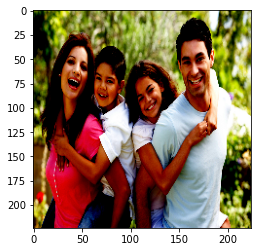

In [18]:
plt.imshow(X_test[1])

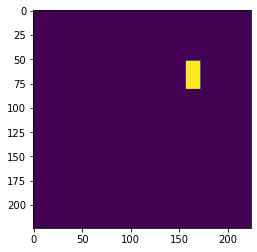

In [19]:
plt.imshow(masks[1])

In [20]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[1]]))[0] > 0.5), (224, 224)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


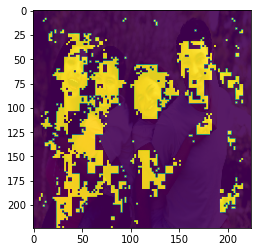

In [21]:
plt.imshow(X_test[1])
plt.imshow(pred_mask, alpha=0.9)

# PART TWO

In [24]:
import glob
import os

In [33]:
path = os.path.join("Downloads\\Part2\\training_images\\",'*g') 
files = glob.glob(path)
dataPart2 = []
for f1 in files:
    img = cv2.imread(f1)
    dataPart2.append(img)

In [34]:
dataPart2[0]

array([[[ 93, 186, 201],
        [ 89, 182, 197],
        [ 82, 177, 192],
        ...,
        [139, 156, 213],
        [136, 153, 210],
        [139, 158, 215]],

       [[ 79, 172, 187],
        [ 78, 173, 188],
        [ 79, 174, 189],
        ...,
        [138, 154, 213],
        [134, 150, 209],
        [137, 153, 212]],

       [[ 62, 157, 172],
        [ 67, 162, 177],
        [ 74, 171, 185],
        ...,
        [132, 146, 205],
        [127, 143, 202],
        [131, 147, 206]],

       ...,

       [[107,  75,  99],
        [111,  79, 103],
        [117,  86, 107],
        ...,
        [ 32,  21,  23],
        [ 31,  22,  25],
        [ 32,  23,  26]],

       [[105,  76,  99],
        [109,  80, 103],
        [114,  85, 108],
        ...,
        [ 31,  20,  22],
        [ 31,  22,  25],
        [ 33,  24,  27]],

       [[109,  80, 103],
        [114,  85, 108],
        [119,  90, 113],
        ...,
        [ 30,  19,  21],
        [ 33,  22,  25],
        [ 33,  24,  27]]

In [36]:
from os import walk
_, _, filenames = next(walk("Downloads\\Part2\\training_images\\"))

In [37]:
filenames

['real_00001.jpg',
 'real_00002.jpg',
 'real_00003.jpg',
 'real_00004.jpg',
 'real_00005.jpg',
 'real_00006.jpg',
 'real_00007.jpg',
 'real_00008.jpg',
 'real_00009.jpg',
 'real_00010.jpg',
 'real_00011.jpg',
 'real_00012.jpg',
 'real_00013.jpg',
 'real_00014.jpg',
 'real_00015.jpg',
 'real_00016.jpg',
 'real_00017.jpg',
 'real_00018.jpg',
 'real_00019.jpg',
 'real_00020.jpg',
 'real_00021.jpg',
 'real_00022.jpg',
 'real_00023.jpg',
 'real_00024.jpg',
 'real_00025.jpg',
 'real_00026.jpg',
 'real_00027.jpg',
 'real_00028.jpg',
 'real_00029.jpg',
 'real_00030.jpg',
 'real_00031.jpg',
 'real_00032.jpg',
 'real_00033.jpg',
 'real_00034.jpg',
 'real_00035.jpg',
 'real_00036.jpg',
 'real_00037.jpg',
 'real_00038.jpg',
 'real_00039.jpg',
 'real_00040.jpg',
 'real_00041.jpg',
 'real_00042.jpg',
 'real_00043.jpg',
 'real_00044.jpg',
 'real_00045.jpg',
 'real_00046.jpg',
 'real_00047.jpg',
 'real_00048.jpg',
 'real_00049.jpg',
 'real_00050.jpg',
 'real_00051.jpg',
 'real_00052.jpg',
 'real_00053

In [42]:
len(filenames)

1091

In [44]:
x_cord=[]
y_cord=[]
height=[]
width=[]
image_name=[]

In [60]:
import cv2
for i in range (len(filenames)):
    face_cascade=cv2.CascadeClassifier("C:\\Users\\mugdha\\anaconda3\\pkgs\\libopencv-3.4.2-h20b85fd_0\\Library\\etc\\haarcascades\\haarcascade_frontalface_default.xml")
    data_path = os.path.join("Downloads\\Part2\\training_images\\",filenames[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)
    
    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    if len(faces)==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=filenames[i]
    
    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    image_name.append(name)


In [63]:
import pandas as pd

DB = pd.DataFrame(x_cord, columns = ['x'])

DB['y']=y_cord
DB['w']=width
DB['h']=height
DB['Image_Name']=image_name

DB.head()

,x,y,w,h,Image_Name
0,157,148,418,418,real_00001.jpg
1,82,142,433,433,real_00002.jpg
2,262,13,125,125,real_00003.jpg
3,130,169,362,362,real_00004.jpg
4,52,197,345,345,real_00005.jpg


In [62]:
#challenges faced during this task - 
#Difficulty in inporting xml file for face cascade - had to download the file and use full path

# PART FOUR

In [65]:
#using cap.read to read all frames in the video; converted into grayscale image

In [66]:
cap = cv2.VideoCapture('Downloads/Part4Video/Video/video1.mp4')

In [ ]:
car_classifier = cv2.CascadeClassifier('C:\\Users\\mugdha\\anaconda3\\pkgs\\libopencv-3.4.2-h20b85fd_0\\Library\\etc\\haarcascades\\cars.xml')
while cap.isOpened():
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cars = car_classifier.detectMultiScale(gray, 1.1, 2)
    for (x,y,w,h) in cars:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
        cv2.imshow('Cars', frame)
    if cv2.waitKey(33) == 27:
        break
cap.release()
cv2.destroyAllWindows()